<a href="https://colab.research.google.com/github/Nathan-oc/Estudos-DSNP/blob/main/EDA_Titanic_R%C3%89PLICA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

**Esse notebook é uma réplica desse [aqui]('https://github.com/mrdbourke/your-first-kaggle-submission/blob/master/kaggle-titanic-dataset-example-submission-workflow.ipynb').**

Nesse notebook vou explorar diversas ferramentas (mais que em outros notebooks) de EDA (Analise Exploratória de Dados). 

A ideia é explorar os dados e encontrar relações e extrair insights antes mesmo de treinar um modelo de machine learning por exemplo.

Vamos importar os dados do conhecido problema do Titanic do [Kaggle]('https://preparo.com.br/oportunidades/62fd67568aa5f7008a6f53af').

Aqui a pergunta que queremos resolver é: seria possível estimar se um passageiro sobreviveria ao acidente do Titanic conforme suas características, baseando-se em outros passageiros sobreviventes?

## Importar bibliotecas

Vamos importar diversas bibliotecas, seja para tratar os dados, para visualização e para criação de modelos de ML 

In [2]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 7.8 MB/s eta 0:00:00


In [4]:
# importar dependências
%matplotlib inline

# bibliotecas básicas
import math, time, datetime, random

# para manipular os dados 
import pandas as pd
import numpy as np

# visualização
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
plt.style.use('seaborn-whitegrid')

# pré-processamento
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# vamos ignorar todos os avisos
import warnings
warnings.filterwarnings('ignore')

## Importar dados

In [135]:
treino = pd.read_csv('https://raw.githubusercontent.com/Nathan-oc/Estudos-DSNP/main/M%C3%B3dulo%202/Titanic%20EDA/train.csv', index_col = 'PassengerId')
teste = pd.read_csv('https://raw.githubusercontent.com/Nathan-oc/Estudos-DSNP/main/M%C3%B3dulo%202/Titanic%20EDA/test.csv', index_col = 'PassengerId')
submissao = pd.read_csv('https://raw.githubusercontent.com/Nathan-oc/Estudos-DSNP/main/M%C3%B3dulo%202/Titanic%20EDA/gender_submission.csv', 
                    index_col = 'PassengerId')

# Desenvolvimento da análise

Vamos começar dando uma olhada de como são os dados e suas variáveis

In [6]:
treino.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


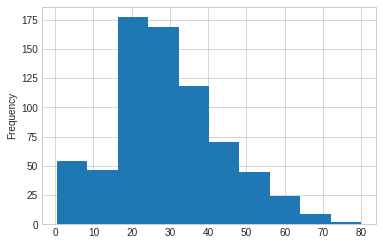

In [7]:
treino.Age.plot.hist()

In [8]:
teste.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [9]:
submissao.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


## Descrição dos dados

Agora temos que destrinchar o que é cada variável e seus tipos:

* `PassengerId`: número de identificação do passageiro;
* `Survived`: se o passageiro sobreviveu ou não. 0 = Não e 1 = Sim;
* `Pclass`: classe do ticket do passageiro. 1 = Primeira classe, 2 = Segunda classe e 3 = Terceira classe;
* `Name`: nome do passageiro;
* `Sex`: gênero biológico do passageiro;
* `Age`: idade do passageiro;
* `Sibsp`: número de irmãos e/ou cônjuges no navio;
* `Parch`: número de pais e/ou filhos no navio;
* `Ticket`: número da passagem;
* `Fare`: tarifa do passageiro ;
* `Cabin`: número da cabine;
* `Embarked`: porto que embarcou.




In [10]:
treino.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [11]:
teste.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [12]:
submissao.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Survived  418 non-null    int64
dtypes: int64(1)
memory usage: 6.5 KB


A grosso modo, variáveis com `int` ou `float` são variáveis numéricas e variavéis com tipo `object` são categóricas.

Entretanto, algumas variáveis que seriam numéricas podem ser categóricas, assim como variáveis do tipo object podem não representar uma categoria, como por exemplo o nome de cada passageiro. 

As próximas etapas são para tratar os dados de forma que fique o melhor possível para aplicar nos modelos de aprendizado. 

Idealmente, todas as variáveis podem ser transformadas em parâmetros numéricos.

## Valores ausentes

Vamos identificar variáveis que possuem valores ausentes e lidar com eles.

É importante ter noção já no começo quais variáveis possume 'buracos' para dar o tratamento devido a elas.

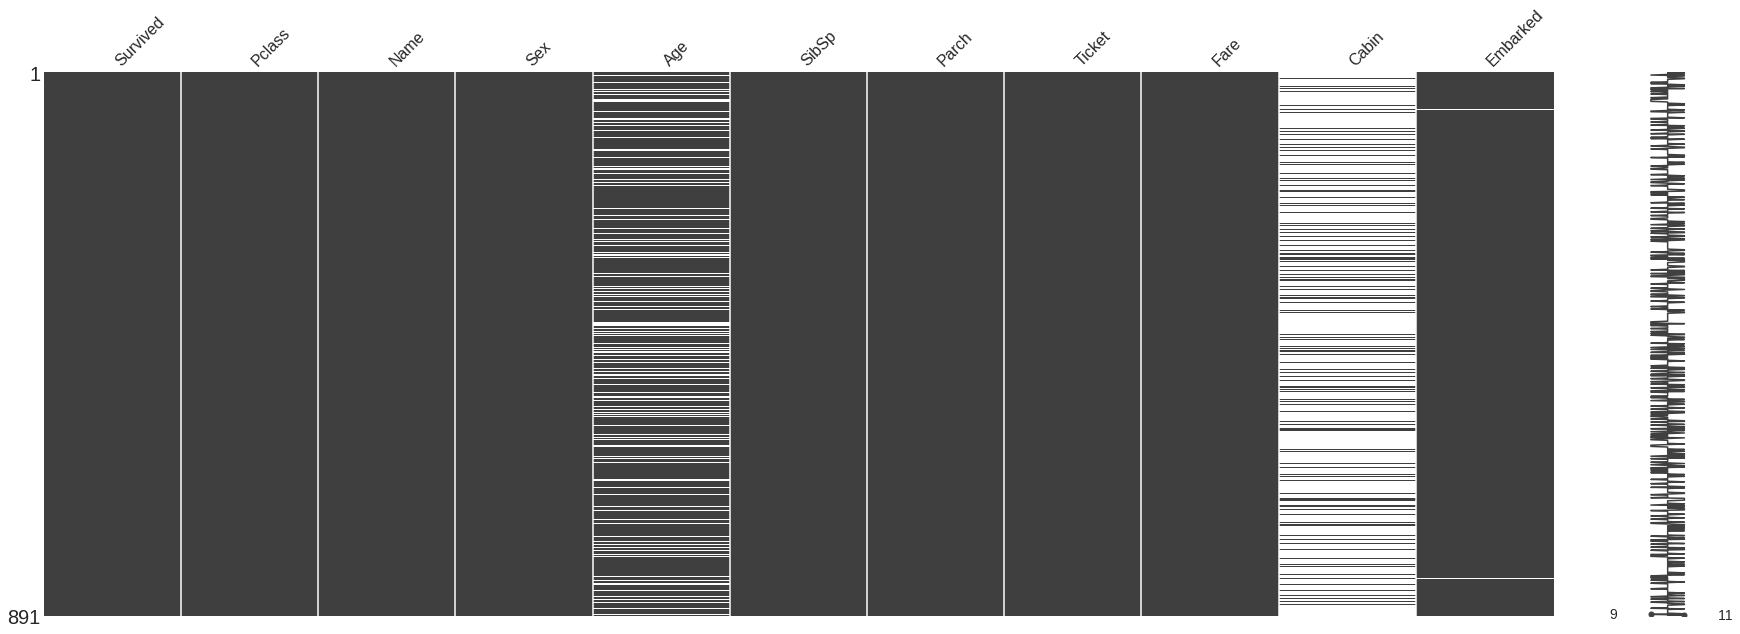

In [13]:
# plotar um gráfico com os valores ausentes
missingno.matrix(treino, figsize = (30, 10))


A variável `cabin` é a que possui a maior parte dos valores faltantes, porém, não será um grande problema pois podemos imaginar que não terá uma influência no resultado final.

Entreanto, a variável `Age` também possui um número considerável de valores ausentes o que pode ser um problema pois podemos supor que tem uma influência direta no resultado final.

In [14]:
treino.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

## Separação de variáveis

Para realizar a análise vou dividir o conjunto em dois, um para variáveis contínuas e outra para variáveis discretas (incluso variáveis categóricas e contínuas discretizadas):

In [15]:
df_disc = pd.DataFrame()
df_cont = pd.DataFrame()

## Exploração de variáveis

Vamos realizar o tratamento e análise de cada coluna separadamente. Algumas vão precisar de trabalho de pré-processamento maior que outras.

In [16]:
treino.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Função de visualização

In [17]:
def plot_count_dist(data, disc_df, label_column, target_column, figsize=(20,5), use_disc_df=False):
  """
  Função para plotar a contagem e a distribuição de uma variável e a variável alvo lado a lado
  ::param_data:: = dataframe
  ::param_disc_df:: = dataframe discretizado
  ::param_label_column:: = coluna de classificação binária
  ::param_target_column:: = coluna que queremos ver a contagem e a distribuição
  ::figsize:: = tamanho da imagem
  ::param_use_disc_df:: = se usará ou não o dataframe discretizado, padrão = Falso
  
  """

  if use_disc_df:
    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    sns.countplot(y = label_column, data=disc_df)
    plt.subplot(1, 2, 2)
    sns.histplot(data=disc_df, hue=target_column, x=label_column, multiple='dodge', kde=True)

  else:
    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    sns.countplot(y = label_column, data=data)
    plt.subplot(1, 2, 2)
    sns.histplot(data=data, hue=target_column, x=label_column, multiple='dodge', kde=True)




### Variável alvo: `Survived` 

Essa é a variável que quero que o modelo preveja a partir de outros.

Temos que: 0 = não sobreviveu e 1 = sobreviveu.

0    549
1    342
Name: Survived, dtype: int64


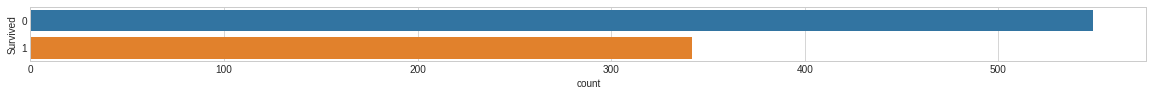

In [18]:
# Quantas pessoas sobreviveram
fig = plt.figure(figsize = (20, 1))
sns.countplot(y='Survived', data=treino) # plota a contagem de valores em barras
print(treino.Survived.value_counts())

In [19]:
# vamos adicionar aos dfs separados
df_disc['Survived'] = treino['Survived']
df_cont['Survived'] = treino['Survived']
df_disc.head()

,Survived
PassengerId,
1,0
2,1
3,1
4,1
5,0


### Variável: ´Pclass`

Representa a classe do passageiro. 1 = primeira classe, 2 = segunda classe e 3 = terceira classe.

Vamos plotar a distribuição para ver como os dados estão distribuídos. Por exemplo, se há valores fora da distribuição talvez não queiramos inseri-los no modelo.

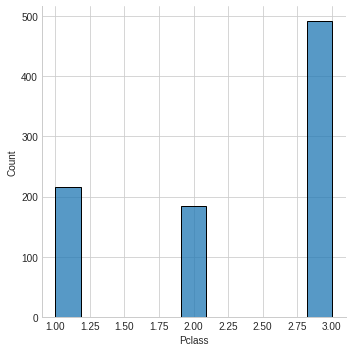

In [20]:
sns.displot(treino.Pclass);

Apesar de ser numérica, essa variável representa categorias, pois um passageiro da terceira classe não é igual a um passageiro da primeira classe somado aum passageiro da classe 2.



In [21]:
treino.Pclass.isnull().sum()

0

Como não há valores faltantes, podemos inserir no nossos subconjuntos.

In [22]:
df_cont['Pclass'] = treino['Pclass']
df_disc['Pclass'] = treino['Pclass']
df_disc.head()

,Survived,Pclass
PassengerId,,
1,0,3
2,1,1
3,1,3
4,1,1
5,0,3


### Variável: `Name`

Descrição: nome do passageiro

In [23]:
# vamos ver se há nomes iguais
treino.Name.value_counts(ascending=False)

Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: Name, Length: 891, dtype: int64

Cada linha possui um nome único, como se fosse o ID do passageiro. 

Podemos pensar em formas de diminuir o número de nomes diferentes? 

Ou criar novas features a partir dos nomes? Uma forma seria extrair as partículas Mr., Miss., Mrs. e Ms. e criar uma coluna para essas. 



### Variável: `Sex`

Descrição: sexo declarado do passageiro (male ou female).


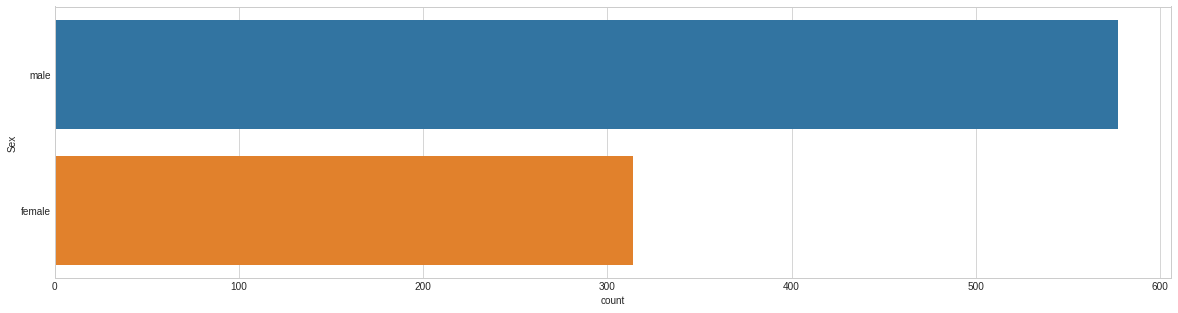

In [24]:
# vamos ver a distribuição 
plt.figure(figsize = (20, 5))
sns.countplot(y = 'Sex', data = treino)

In [25]:
treino.Sex.isnull().sum()

0

In [26]:
df_disc['Sex'] = treino.Sex
df_disc['Sex'].mask(df_disc['Sex'] == 'female', 'F', inplace=True)
df_disc['Sex'].mask(df_disc['Sex'] == 'male', 'M', inplace=True)

df_cont['Sex'] = treino.Sex
df_disc.head()

,Survived,Pclass,Sex
PassengerId,,,
1,0,3,M
2,1,1,F
3,1,3,F
4,1,1,F
5,0,3,M


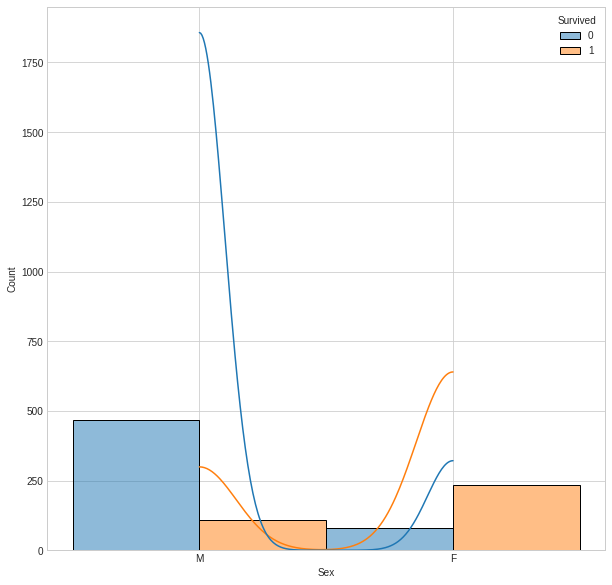

In [27]:
# Já que Sex e Survived são variáveis binárias
# vamos plotar ambas juntas
plt.figure(figsize = (10, 10))
sns.histplot(data=df_disc, hue="Survived", x="Sex", multiple='dodge', kde=True) 

ValueError: ignored

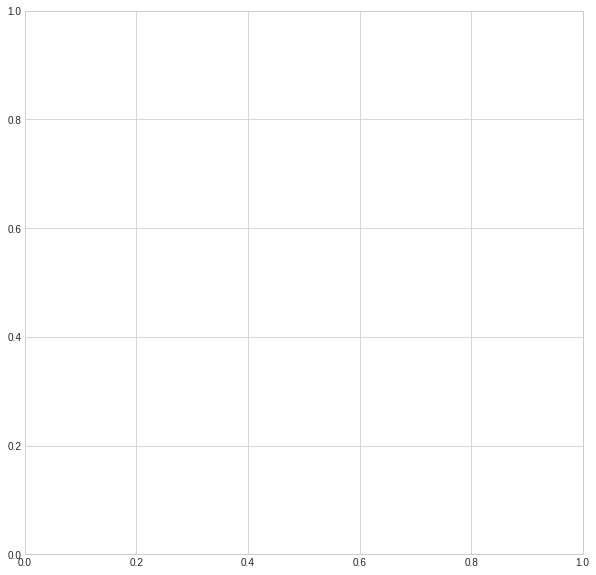

In [28]:
# Já que Sex e Survived são variáveis binárias
# vamos plotar ambas juntas
plt.figure(figsize = (10, 10))
sns.distplot(df_disc.loc[df_disc.Survived == 1]['Sex']);
sns.distplot(df_disc.loc[df_disc.Survived == 0]['Sex']);

In [ ]:
# Já que Sex e Survived são variáveis binárias
# vamos plotar ambas juntas
plt.figure(figsize = (10, 10))
sns.displot(data=df_disc, hue="Survived", x="Sex", multiple='dodge', kde=True) 
# data indica a base que estamos usando,
# x indica a variável que estará nesse eixo
# hue represeta qual variável será a de separação das cores
# multiple ='dodge' indica que é para as barras ficarem uma do lado da outra
# kde = True pede para que plote as linhas contínuas

Note que muitos passageiros não sobreviveram mas dos que sobreviveram a maioria eram mulheres e foi uma proporção muito maior do que a proporção de homens que sobreviveram. 

### Variável: `Age`

Descrição: indica a idade do passageiro.



In [ ]:
treino.Age.isnull().sum(), treino.Age.isnull().sum() / treino.shape[0]

Podemos ver que quase 20% dos dados estão com a variável `Age` faltante. 

É necessário ter algum tratamento com esses valores ausentes.

Vamos excluir todos os dados que possuem ausentes? São muitos dados, portanto, excluí-los da análise pode ser prejudicial.

Desconsiderar a variável `Age` da nossa análise e modelo? A análise não fica (tão) comprometida e pode até ser feita com os valores ausentes, entretanto, o modelo desconsiderar essa variável pode ter uma perda significativa de eficiência.

Preencher esses valores com algum valor, por exemplo média, mediana? Ou até mesmo considerar os dados que são parecidos e calcular a média da variável `Age` apenas desses dados? Vamos supor que a média seja $35$, se preenchermos todos os valores ausentes com $35$ podemos enviesar consideravelmente a análise e o modelo.

Talvez seja interessante utilizar a função `interpolate()`.

Deve-se tratar esses dados antes de adicioná-los aos subdataframes.

In [29]:
# df_disc['Age'] = pd.cut(treino['Age'], 10) # dividir a variável continua em 10 categoria
# df_cont['Age'] = treino.Age

### Variável: `SibSp`

Descrição: indica o número de irmãos e cônjuges que o passageiro possui a bordo do Titanic.



In [30]:
treino.SibSp.isnull().sum()

0

In [31]:
treino.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

Vamos adicionar a variável aos nossos dataframes e plotar a distribuição:

In [32]:
df_disc['SibSp'] = treino.SibSp
df_cont['SibSp'] = treino.SibSp
df_disc.head()

,Survived,Pclass,Sex,SibSp
PassengerId,,,,
1,0,3,M,1
2,1,1,F,1
3,1,3,F,0
4,1,1,F,1
5,0,3,M,0


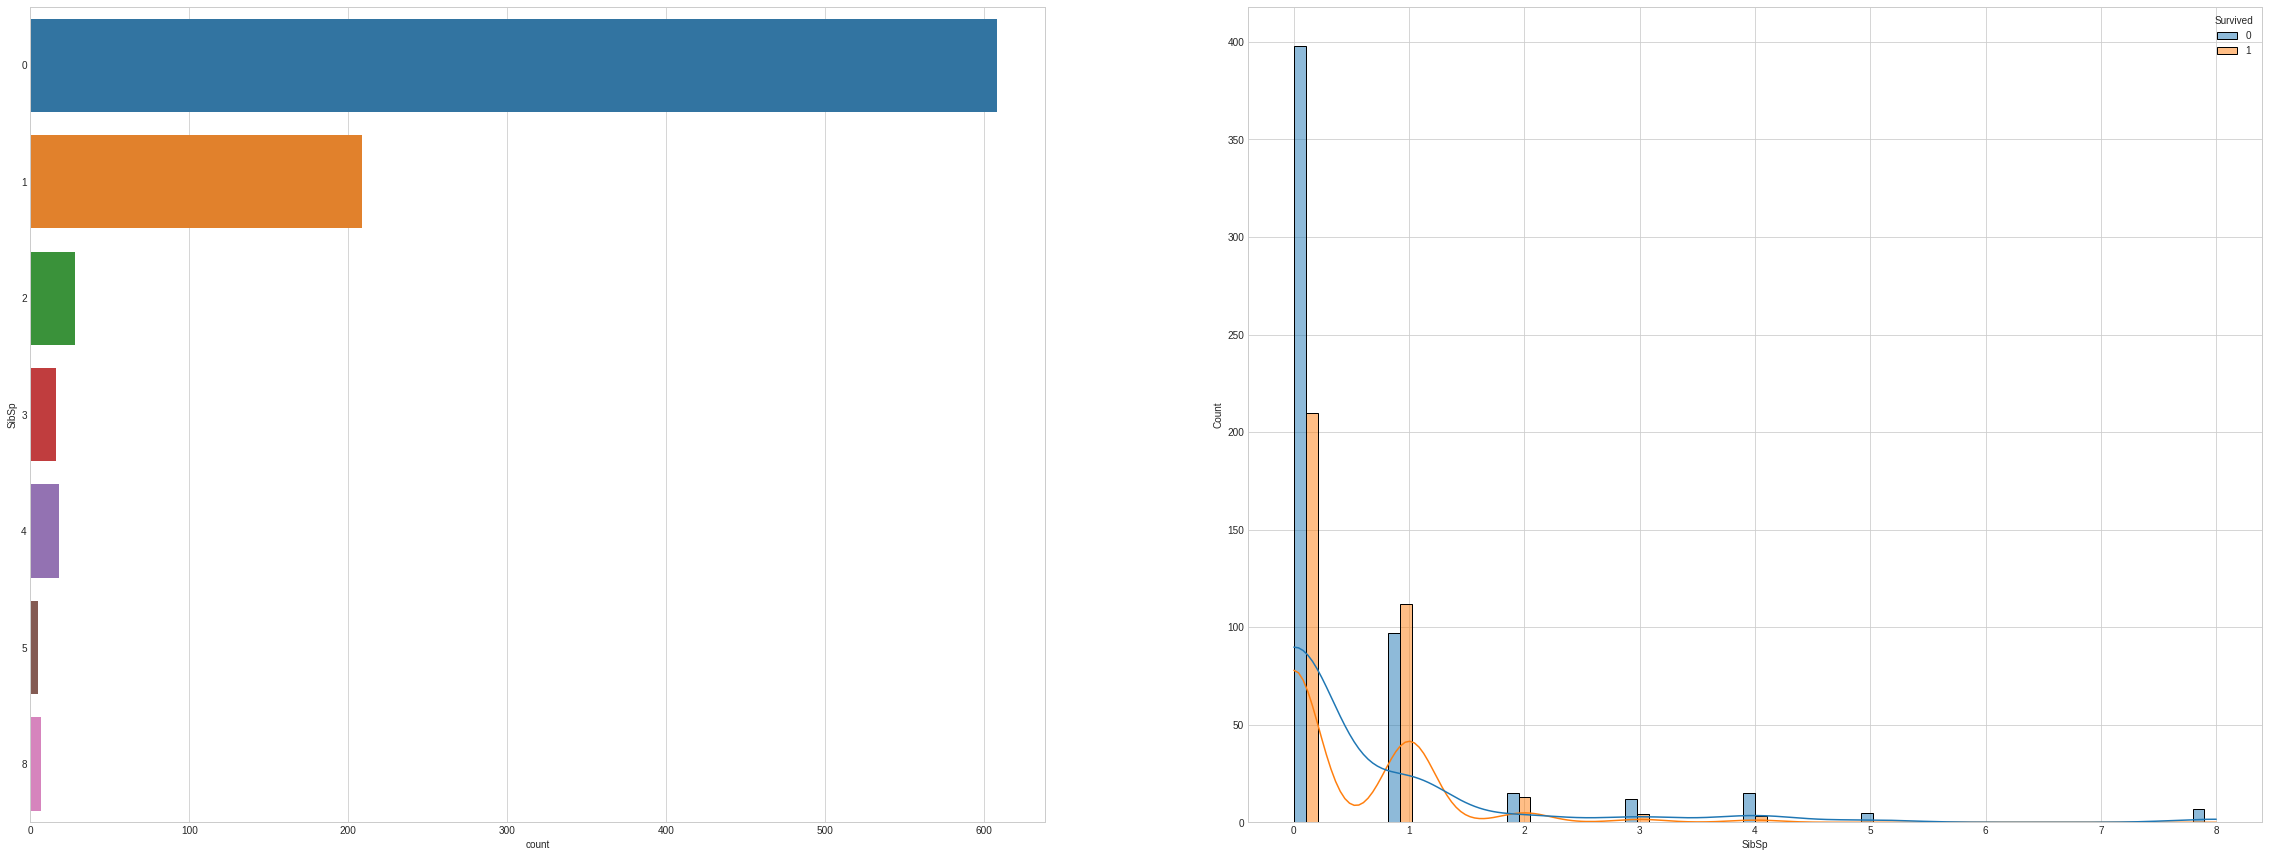

In [33]:
plot_count_dist(treino, disc_df = df_disc, label_column='SibSp', target_column='Survived', figsize=(40,15))

É possível reparar que para quem possuia 1 ou 2 irmãos/cônjuges, a proporção de sobriventes foi alta, basicamente 50%. Já para quem não possui, a proporção foi de 33% aproximadamente. E por fim, a proporção foi extremamente baixa para quem possuía 3 ou mais.

### Variável: `Parch`

Descrição: número de pais e filhos a bordo no Titanic.

Uma vez que é parecida com a variável `SibSp`, será feito uma análise similar.

In [34]:
treino.Parch.isnull().sum()

0

In [35]:
treino.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [36]:
df_disc['Parch'] = treino['Parch']
df_cont['Parch'] = treino['Parch']
df_disc.head()

,Survived,Pclass,Sex,SibSp,Parch
PassengerId,,,,,
1,0,3,M,1,0
2,1,1,F,1,0
3,1,3,F,0,0
4,1,1,F,1,0
5,0,3,M,0,0


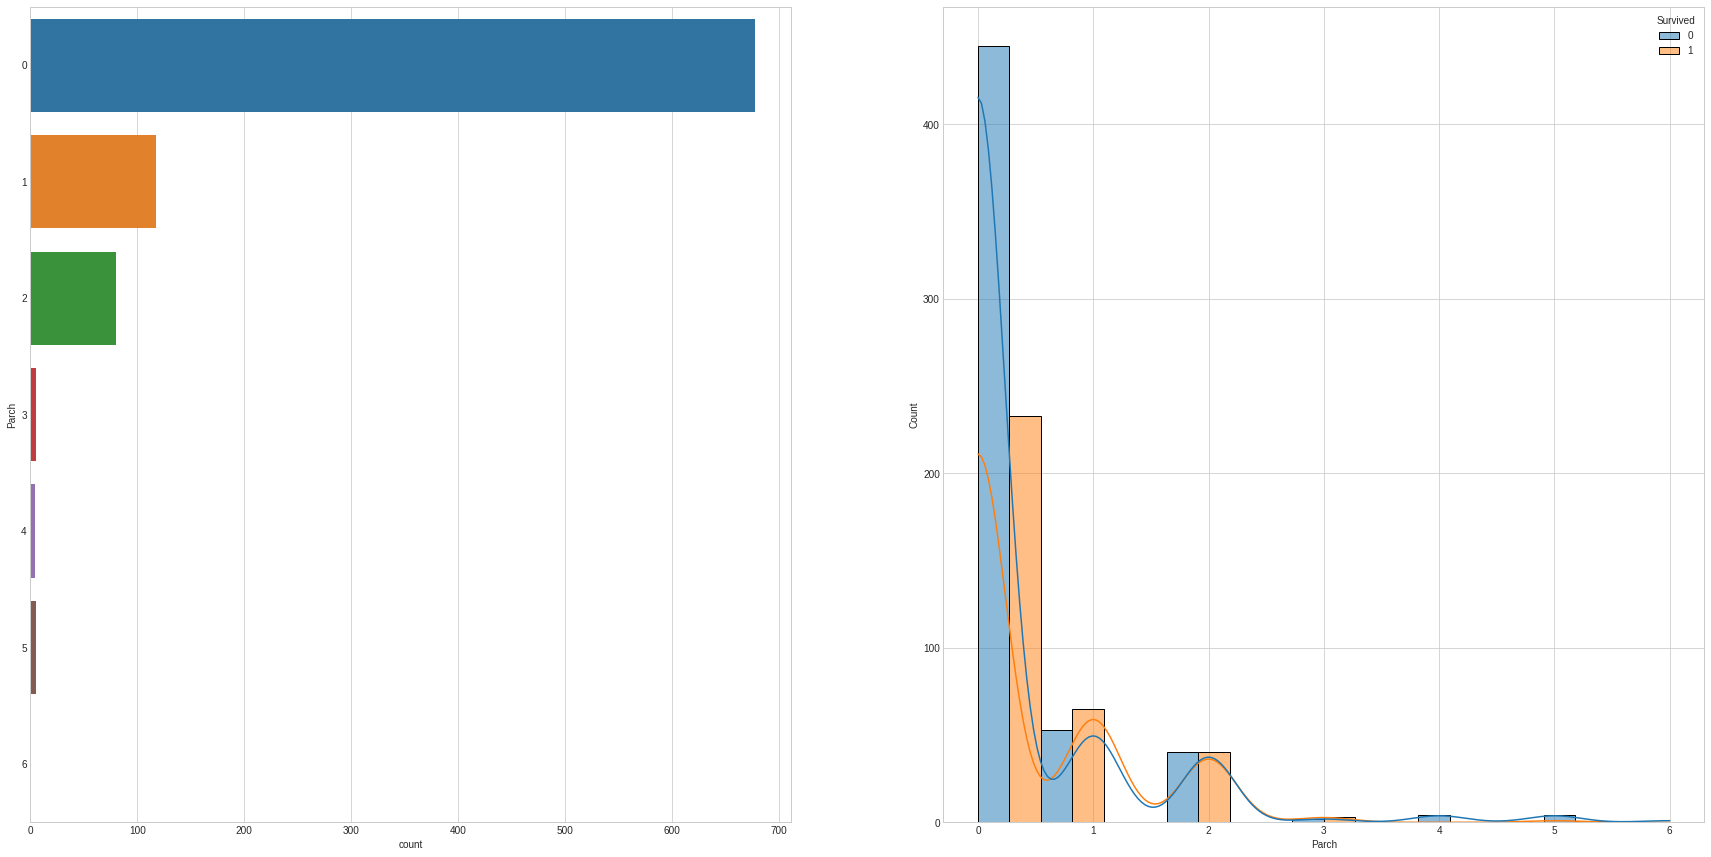

In [37]:
plot_count_dist(data=treino, 
                disc_df=df_disc,
                label_column = 'Parch',
                target_column='Survived',
                figsize=(30,15))

É possível reparar que a proporção foi consideravelmente alta para aqueles que possuiam 1, 2 ou 3 pais/filhos. Já para quem não possuía, a proporção foi relativamente baixa e para aqueles que possuiam 4 ou mais a proporção foi 0.

Será que poderia ser combinada essa e a variável `SibSp` para ver se o passageiro estava sozinho ou não.

### Variável: `Ticket`

Descrição: número da passagem.



In [38]:
treino.Ticket.isnull().sum()

0

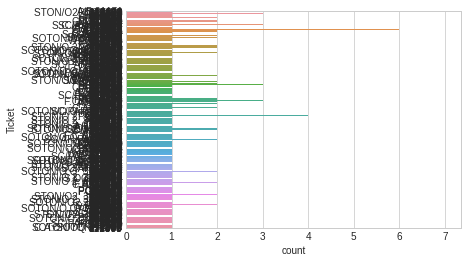

In [39]:
sns.countplot(y='Ticket', data=treino)

In [40]:
treino.Ticket.value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [41]:
print("Há {} números de passagens diferentes.".format(len(treino.Ticket.unique())))

Há 681 números de passagens diferentes.


681 números de passagens diferentes é muita coisa, portanto, vamos desconsiderar a variável da nossa análise e modelo. É até natural imaginar que o número da passagem não interfira diretamente no resutalto, uma vez que o máximo de informação que pode fornecer é uma diferença de classe social entre os passageiros mas isso já é muito bem fornecido pela variável `Pclass` e possivelmente pela variável `Cabin`

Entretanto, pode ser feito um trabalho nessa variável assim como na feature `Name` e quiça extrair alguma informação relevante. Além de ser possível reduzir esse número de passagens diferentes.

### Variável: `Fare`

Descrição: quanto custou a passagem.

In [42]:
treino.Fare.isnull().sum()

0

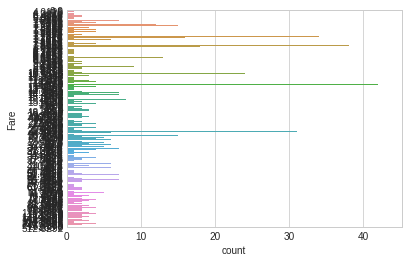

In [43]:
sns.countplot(y='Fare', data=treino)

In [44]:
treino.Fare.value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
35.0000     1
28.5000     1
6.2375      1
14.0000     1
10.5167     1
Name: Fare, Length: 248, dtype: int64

In [45]:
treino.Fare.dtypes

dtype('float64')

In [46]:
print("Há {} valores diferentes de passagens.".format(len(treino.Fare.unique())))

Há 248 valores diferentes de passagens.


Como é uma variável float vamos adicionar ao dataframe contínuo mas também vamos adicionar ao outro, discretizando.

In [47]:
df_disc['Fare'] = pd.cut(treino['Fare'], bins=5)
df_cont['Fare'] = treino['Fare']
df_disc.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare
PassengerId,,,,,,
1,0,3,M,1,0,"(-0.512, 102.466]"
2,1,1,F,1,0,"(-0.512, 102.466]"
3,1,3,F,0,0,"(-0.512, 102.466]"
4,1,1,F,1,0,"(-0.512, 102.466]"
5,0,3,M,0,0,"(-0.512, 102.466]"


In [48]:
df_disc.Fare = df_disc.Fare.astype(str)

In [49]:
df_disc.Fare.value_counts()

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
Name: Fare, dtype: int64

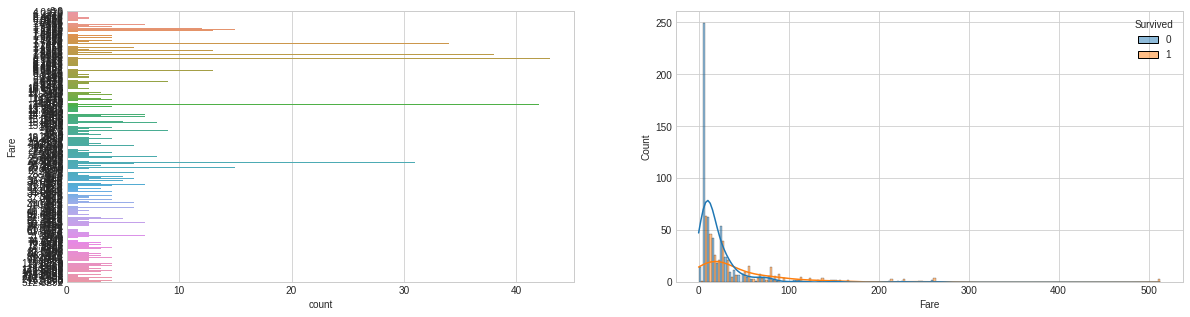

In [50]:
plot_count_dist(data=treino, disc_df = df_disc, label_column = 'Fare', target_column = 'Survived', use_disc_df=False)

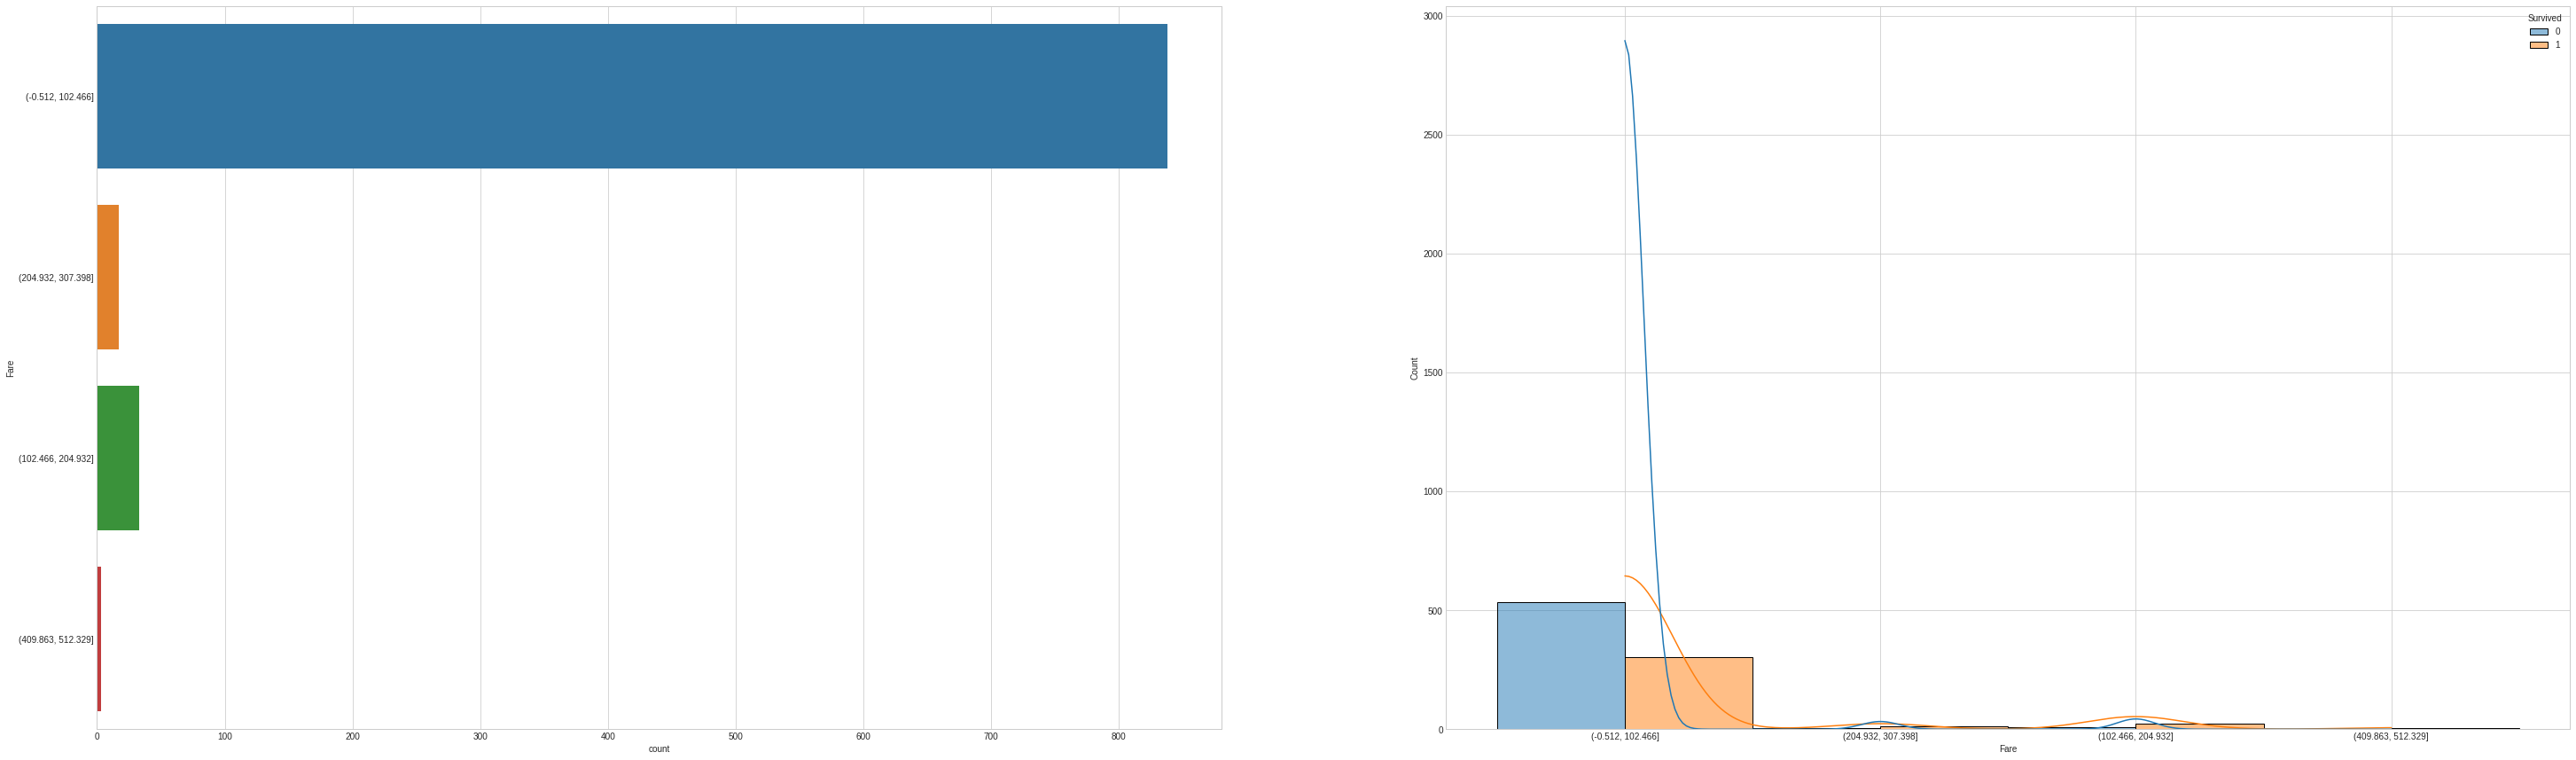

In [51]:
plot_count_dist(data = treino, disc_df = df_disc, label_column = 'Fare', target_column = 'Survived', use_disc_df=True, figsize=(50,15))

É de reparar que a esmagadora maioria dos valores estão no primeiro intervalo. Seria interessante fazer outra divisão de forma que os valores fiquem melhores distribuídos.

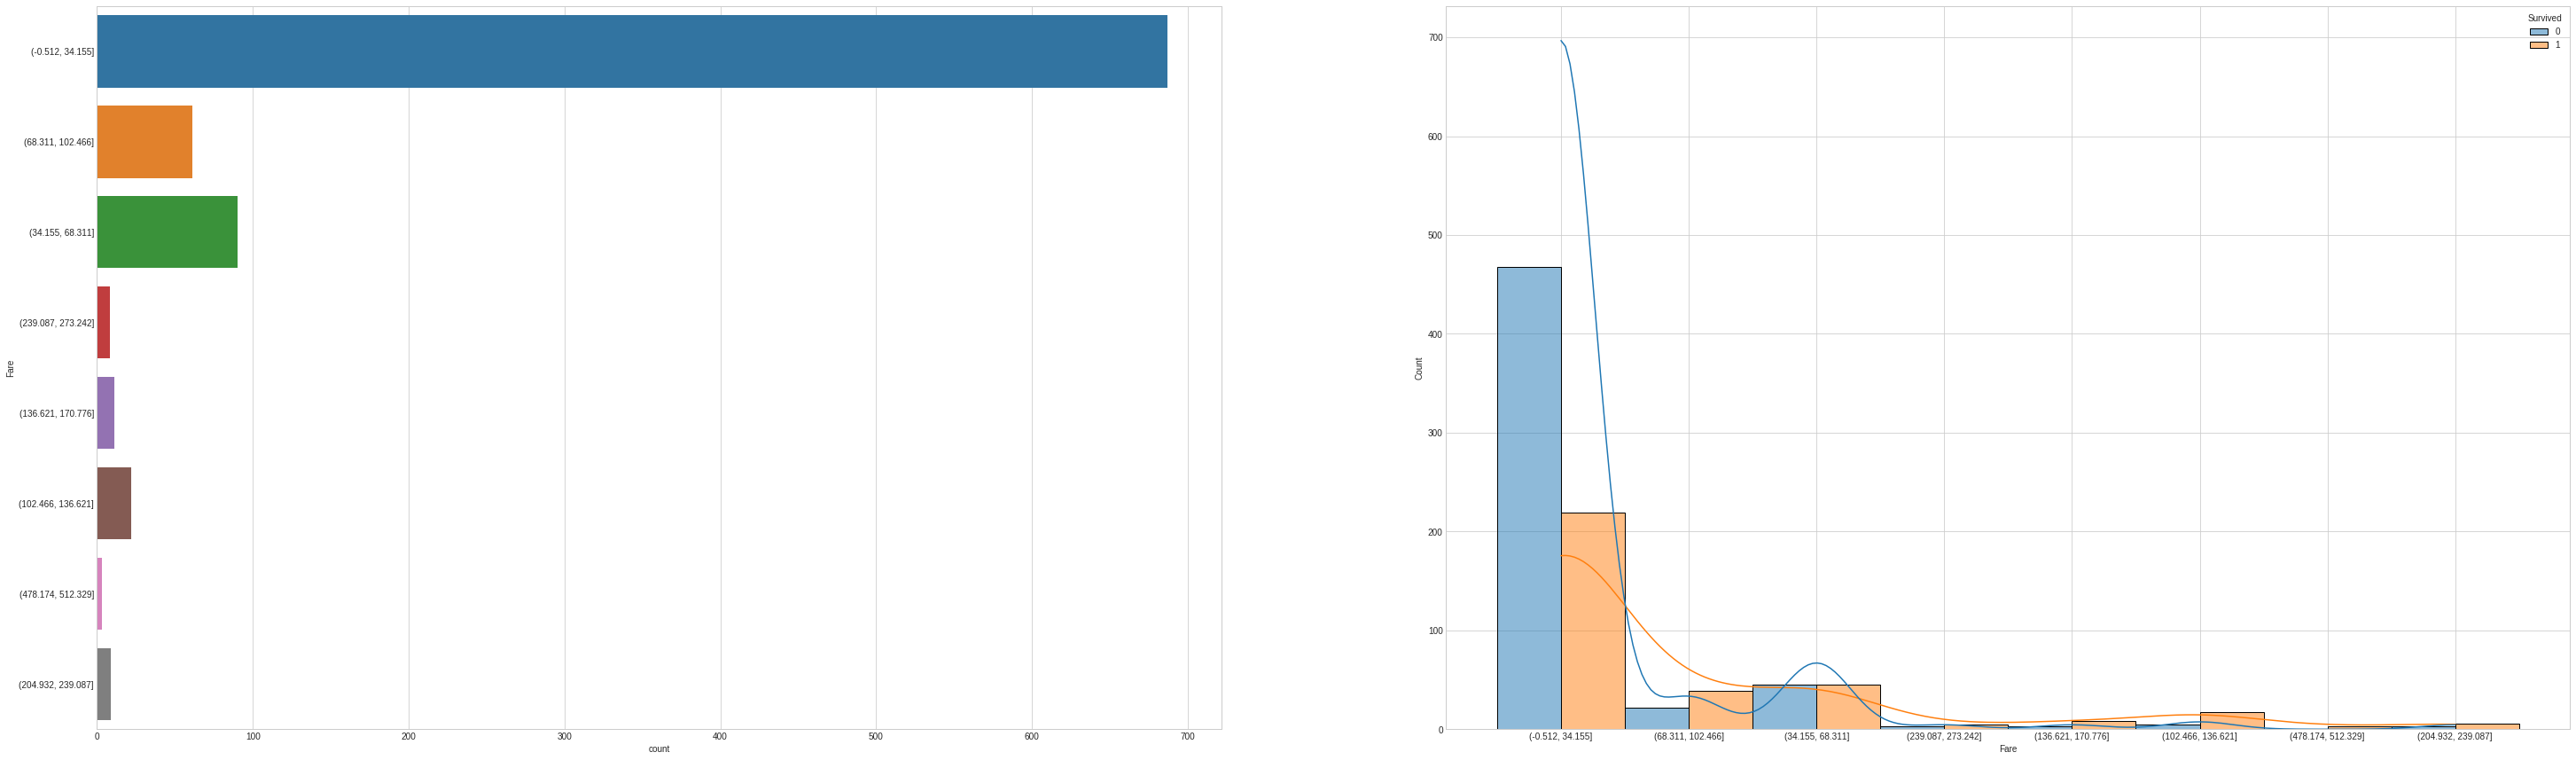

In [52]:
df_disc['Fare'] = pd.cut(treino['Fare'], bins=15)
df_disc.Fare = df_disc.Fare.astype(str)
plot_count_dist(data = treino, disc_df = df_disc, label_column = 'Fare', target_column = 'Survived', use_disc_df=True, figsize=(50,15))

Notável que para quem pagou maiores valores de passagem a proporção de sobreviventes também foi maior.

### Variável: Cabin

Descrição: número da cabine do passageiro.

In [53]:
treino.Cabin.isnull().sum(), treino.Cabin.isnull().sum() / treino.shape[0]

(687, 0.7710437710437711)

Há uma quantidade enorme de valores ausentes.


In [54]:
treino.Cabin.head()

PassengerId
1     NaN
2     C85
3     NaN
4    C123
5     NaN
Name: Cabin, dtype: object

In [55]:
treino.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

Por haver muitos valores ausentes, essa variável não será levada em conta para análise e modelo. 

Porém, o que poderia ser feito para que seja uma variável útil? E como trataria os valores ausentes?

### Variável: Embarked

Descrição: o porto que o passageiro embarcou. É uma variável categórica. 

C = Cherbourg, Q = Queenstown e S = Southampton.

In [56]:
treino.Embarked.isnull().sum()

2

In [57]:
treino.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Como lidar com os valores ausentes?

Podemos assinalar aleatoriamente uma categoria  para cada valor ausente. Ou, simplesmente excluir as duas linhas (é o que faremos).


In [58]:
df_disc['Embarked'] = treino.Embarked
df_cont['Embarked'] = treino.Embarked
df_disc = df_disc.dropna(subset=['Embarked'])
df_cont = df_cont.dropna(subset=['Embarked'])

## Feature encoding

Agora vamos fazer algumas mudanças nos valores de algumas variáveis para que seja amigável ao uso em modelos de ML. 

Vamos  implementar one hot encoding (uma classificação binária) em `df_disc` e label encoding em `df_cont`. 

In [59]:
df_disc.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,0,3,M,1,0,"(-0.512, 34.155]",S
2,1,1,F,1,0,"(68.311, 102.466]",C
3,1,3,F,0,0,"(-0.512, 34.155]",S
4,1,1,F,1,0,"(34.155, 68.311]",S
5,0,3,M,0,0,"(-0.512, 34.155]",S


In [60]:
# one hot encoding
cols = df_disc.columns.tolist()
cols.remove('Survived')
df_disc_enc = pd.get_dummies(df_disc, columns = cols) # transforma em variáveis binárias
df_disc_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_F,Sex_M,SibSp_0,SibSp_1,SibSp_2,SibSp_3,...,"Fare_(102.466, 136.621]","Fare_(136.621, 170.776]","Fare_(204.932, 239.087]","Fare_(239.087, 273.242]","Fare_(34.155, 68.311]","Fare_(478.174, 512.329]","Fare_(68.311, 102.466]",Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
3,1,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,1,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
5,0,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [61]:
df_cont.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,0,3,male,1,0,7.2500,S
2,1,1,female,1,0,71.2833,C
3,1,3,female,0,0,7.9250,S
4,1,1,female,1,0,53.1000,S
5,0,3,male,0,0,8.0500,S


In [62]:
# one hot enconding nas variáveis categóricas
df_pclass_enc = pd.get_dummies(df_cont.Pclass, prefix = 'pclass')
df_embarked_enc = pd.get_dummies(df_cont.Embarked, prefix = 'embarked')
df_sex_enc = pd.get_dummies(df_cont.Sex, prefix = 'sex')

df_cont_enc = pd.concat([df_cont,
                        df_pclass_enc,
                        df_sex_enc,
                        df_embarked_enc], axis = 1)

df_cont_enc = df_cont_enc.drop(['Pclass', 'Sex', 'Embarked'], axis = 1)

df_cont_enc.head()

,Survived,SibSp,Parch,Fare,pclass_1,pclass_2,pclass_3,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
PassengerId,,,,,,,,,,,,
1,0,1,0,7.2500,0,0,1,0,1,0,0,1
2,1,1,0,71.2833,1,0,0,1,0,1,0,0
3,1,0,0,7.9250,0,0,1,1,0,0,0,1
4,1,1,0,53.1000,1,0,0,1,0,0,0,1
5,0,0,0,8.0500,0,0,1,0,1,0,0,1


---
# Modelos de Machine Learning

Já que fiz as análises e lidei com os valores dos dados, vou construir diversos modelos de ML e comparar os resultados.

Vou separar os dados:

In [92]:
sel_df = df_cont_enc.copy()

In [93]:
X_treino = sel_df.drop('Survived', axis = 1)
y_treino = sel_df.Survived
X_treino.head()

,SibSp,Parch,Fare,pclass_1,pclass_2,pclass_3,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
PassengerId,,,,,,,,,,,
1,1,0,7.2500,0,0,1,0,1,0,0,1
2,1,0,71.2833,1,0,0,1,0,1,0,0
3,0,0,7.9250,0,0,1,1,0,0,0,1
4,1,0,53.1000,1,0,0,1,0,0,0,1
5,0,0,8.0500,0,0,1,0,1,0,0,1


## Função fit

Como serão usadas diversas funções do pacote scikit e todas apresentam inputs e outputs semelhantes, vou criar uma função que aplique a função específicada nos conjuntos.

In [94]:
def fit_ml(algo, X_treino, y_treino, cv):
  # aplicar o modelo e calcular acurácia
  model = algo.fit(X_treino, y_treino)
  acc = round(model.score(X_treino, y_treino) * 100, 2)

  # validação cruzada
  treino_pred = model_selection.cross_val_predict(algo,
                                                  X_treino,
                                                  y_treino, 
                                                  cv = cv, 
                                                  n_jobs = -1)
  
  # métrica da validação cruzada
  acc_cv = round(metrics.accuracy_score(y_treino, treino_pred) * 100, 2)

  return treino_pred, acc, acc_cv

## Aplicação de modelos

Vamos aplicar cada modelo no conjunto:

### Regressão Logística

In [95]:
start_time = time.time()
treino_pred_log, acc_log, acc_cv_log = fit_ml(LogisticRegression(),
                                              X_treino,
                                              y_treino,
                                              10)
log_time = (time.time() - start_time)
print("Acurácia: %s" % acc_log)
print("Acurácia da CV: %s" % acc_cv_log)
print("Tempo decorrido: %s" % datetime.timedelta(seconds=log_time))

Acurácia: 79.98
Acurácia da CV: 79.42
Tempo decorrido: 0:00:01.892296


### K Vizinhos mais Próximos

In [96]:
start_time = time.time()
treino_pred_knn, acc_knn, acc_cv_knn = fit_ml(KNeighborsClassifier(),
                                              X_treino,
                                              y_treino,
                                              10)
knn_time = (time.time() - start_time)
print("Acurácia: %s" % acc_knn)
print("Acurácia da CV: %s" % acc_cv_knn)
print("Tempo decorrido: %s" % datetime.timedelta(seconds=knn_time))

Acurácia: 83.58
Acurácia da CV: 77.39
Tempo decorrido: 0:00:00.154570


### Gaussian Naive Bayes

In [97]:
start_time = time.time()
treino_pred_gnb, acc_gnb, acc_cv_gnb = fit_ml(GaussianNB(),
                                              X_treino,
                                              y_treino,
                                              10)
gnb_time = (time.time() - start_time)
print("Acurácia: %s" % acc_gnb)
print("Acurácia da CV: %s" % acc_cv_gnb)
print("Tempo decorrido: %s" % datetime.timedelta(seconds=gnb_time))

Acurácia: 78.52
Acurácia da CV: 77.95
Tempo decorrido: 0:00:00.071264


### Máquina de Vetor Suporte (SVC)

In [98]:
start_time = time.time()
treino_pred_svc, acc_svc, acc_cv_svc = fit_ml(LinearSVC(),
                                              X_treino,
                                              y_treino,
                                              10)
svc_time = (time.time() - start_time)
print("Acurácia: %s" % acc_svc)
print("Acurácia da CV: %s" % acc_cv_svc)
print("Tempo decorrido: %s" % datetime.timedelta(seconds=svc_time))

Acurácia: 78.52
Acurácia da CV: 77.17
Tempo decorrido: 0:00:00.400244


### Gradiente Descendente Estocástico

In [99]:
start_time = time.time()
treino_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml(SGDClassifier(),
                                              X_treino,
                                              y_treino,
                                              10)
sgd_time = (time.time() - start_time)
print("Acurácia: %s" % acc_sgd)
print("Acurácia da CV: %s" % acc_cv_sgd)
print("Tempo decorrido: %s" % datetime.timedelta(seconds=sgd_time))

Acurácia: 61.87
Acurácia da CV: 66.93
Tempo decorrido: 0:00:00.121522


### Árvore de Decisão

In [100]:
start_time = time.time()
treino_pred_dt, acc_dt, acc_cv_dt = fit_ml(DecisionTreeClassifier(),
                                              X_treino,
                                              y_treino,
                                              10)
dt_time = (time.time() - start_time)
print("Acurácia: %s" % acc_dt)
print("Acurácia da CV: %s" % acc_cv_dt)
print("Tempo decorrido: %s" % datetime.timedelta(seconds=dt_time))

Acurácia: 92.46
Acurácia da CV: 80.43
Tempo decorrido: 0:00:00.088300


### Árvores Gradient Boost


In [101]:
start_time = time.time()
treino_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml(GradientBoostingClassifier(),
                                              X_treino,
                                              y_treino,
                                              10)
gbt_time = (time.time() - start_time)
print("Acurácia: %s" % acc_gbt)
print("Acurácia da CV: %s" % acc_cv_gbt)
print("Tempo decorrido: %s" % datetime.timedelta(seconds=gbt_time))

Acurácia: 86.61
Acurácia da CV: 80.65
Tempo decorrido: 0:00:01.070626


### Algoritmo Catboost

É um algoritmo de classificação baseado em árvores de decisão. Para saber mais é só acessar o site próprio da [biblioteca](https://catboost.ai/).


In [102]:
# Encontrar variáveis categóricas do dataset
cat_feat = np.where(X_treino.dtypes != np.float)[0]
cat_feat

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10])

In [103]:
treino_pool = Pool(X_treino, y_treino, cat_feat)

In [104]:
# Definição do modelo
catboost_model = CatBoostClassifier(iterations = 1000, custom_loss=['Accuracy'], loss_function = 'Logloss')

# Ajuste do modelo
catboost_model.fit(treino_pool, plot=True)

# Acurácia do modelo
acc_catboost = round(catboost_model.score(X_treino, y_treino) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.009797
0:	learn: 0.6862830	total: 7.68ms	remaining: 7.67s
1:	learn: 0.6813394	total: 10.4ms	remaining: 5.18s
2:	learn: 0.6756637	total: 14ms	remaining: 4.64s
3:	learn: 0.6706235	total: 16.4ms	remaining: 4.07s
4:	learn: 0.6666649	total: 19.6ms	remaining: 3.91s
5:	learn: 0.6611160	total: 23ms	remaining: 3.81s
6:	learn: 0.6563034	total: 25.2ms	remaining: 3.57s
7:	learn: 0.6507823	total: 29ms	remaining: 3.6s
8:	learn: 0.6461982	total: 31.4ms	remaining: 3.46s
9:	learn: 0.6420406	total: 33.7ms	remaining: 3.34s
10:	learn: 0.6374200	total: 40.7ms	remaining: 3.66s
11:	learn: 0.6323259	total: 44ms	remaining: 3.63s
12:	learn: 0.6279649	total: 47.8ms	remaining: 3.63s
13:	learn: 0.6234272	total: 51.3ms	remaining: 3.61s
14:	learn: 0.6192251	total: 54.2ms	remaining: 3.56s
15:	learn: 0.6152438	total: 57ms	remaining: 3.5s
16:	learn: 0.6114510	total: 59.3ms	remaining: 3.43s
17:	learn: 0.6070925	total: 62.8ms	remaining: 3.43s
18:	learn: 0.6024461	total: 66.3ms	remaining: 3.42s
19:	

Vou aplicar validação cruzada:

In [105]:
# Saber quanto tempo vai levar
start_time = time.time()

# Definir os parâmetros iguais ao modelo inicial
cv_params = catboost_model.get_params()

# Aplicar CV de 10 conjuntos
cv_data = cv(treino_pool, cv_params, fold_count = 10, plot=False)

# Quanto tempo levou?
catboost_time = (time.time() - start_time)

# Resultados salvos em um dataframe
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

A saída de streaming foi truncada nas últimas 5000 linhas.
24:	learn: 0.4800917	test: 0.4571620	best: 0.4571620 (24)	total: 89.7ms	remaining: 3.5s
25:	learn: 0.4747490	test: 0.4521527	best: 0.4521527 (25)	total: 93.6ms	remaining: 3.51s
26:	learn: 0.4704994	test: 0.4475063	best: 0.4475063 (26)	total: 97.3ms	remaining: 3.51s
27:	learn: 0.4675701	test: 0.4446419	best: 0.4446419 (27)	total: 101ms	remaining: 3.51s
28:	learn: 0.4637595	test: 0.4411507	best: 0.4411507 (28)	total: 105ms	remaining: 3.51s
29:	learn: 0.4620310	test: 0.4388286	best: 0.4388286 (29)	total: 108ms	remaining: 3.5s
30:	learn: 0.4589029	test: 0.4347657	best: 0.4347657 (30)	total: 112ms	remaining: 3.5s
31:	learn: 0.4576067	test: 0.4330721	best: 0.4330721 (31)	total: 114ms	remaining: 3.46s
32:	learn: 0.4550258	test: 0.4299781	best: 0.4299781 (32)	total: 118ms	remaining: 3.46s
33:	learn: 0.4523643	test: 0.4271601	best: 0.4271601 (33)	total: 122ms	remaining: 3.47s
34:	learn: 0.4493545	test: 0.4239292	best: 0.4239292 (34)	tot

In [106]:
print("- - - Métricas do CatBoost - - -")
print("Acurácia {}".format(acc_catboost))
print("Acurácia da CV: {}".format(acc_cv_catboost))
print("Tempo decorrido: {}".format(datetime.timedelta(seconds=catboost_time)))

- - - Métricas do CatBoost - - -
Acurácia 84.14
Acurácia da CV: 81.43
Tempo decorrido: 0:00:48.381297


## Melhores modelos

Vamos agora avaliar qual foram os melhores modelos, analisando principalmente a acurácia da validação cruzada.

In [107]:
modelos = ['Regressão Logística',
           'KNN',
           'Gaussian Naive Bayes',
           'SVC',
           'SGD',
           'Árvore de Decisão',
           'Árvores Gradient Boosting',
           'Catboost']

acc_modelos = pd.DataFrame(
    {'Score': [acc_log,
               acc_knn,
               acc_gnb,
               acc_svc,
               acc_sgd,
               acc_dt,
               acc_gbt,
               acc_catboost],
     'Score CV': [acc_cv_log,
               acc_cv_knn,
               acc_cv_gnb,
               acc_cv_svc,
               acc_cv_sgd,
               acc_cv_dt,
               acc_cv_gbt,
               acc_cv_catboost],}, index = modelos
)
acc_modelos

,Score,Score CV
Regressão Logística,79.98,79.42
KNN,83.58,77.39
Gaussian Naive Bayes,78.52,77.95
SVC,78.52,77.17
SGD,61.87,66.93
Árvore de Decisão,92.46,80.43
Árvores Gradient Boosting,86.61,80.65
Catboost,84.14,81.43


In [108]:
acc_modelos.sort_values(by='Score CV', ascending = False)

,Score,Score CV
Catboost,84.14,81.43
Árvores Gradient Boosting,86.61,80.65
Árvore de Decisão,92.46,80.43
Regressão Logística,79.98,79.42
Gaussian Naive Bayes,78.52,77.95
KNN,83.58,77.39
SVC,78.52,77.17
SGD,61.87,66.93


Como o modelo CatBoost obteve os melhores resultados, vou prosseguir apenas com ele para análise.

Para se pensar: como eu poderia melhorar o resultado desse modelo?


## Relevância das Variáveis

Aqui vou avaliar quais são as variáveis mais determinantes para fazer uma previsão.

In [109]:
def feat_importancia(modelo, data):
  """
  Função para mostrar quais variáveis são mais relevantes.
  ::param_modelo:: especifica o modelo
  ::param_data:: especifica os dados
  """
  fea_imp = pd.DataFrame({'imp': modelo.feature_importances_, 'col': data.columns})
  fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
  _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20,10))
  return fea_imp

,imp,col
9,1.073557,embarked_Q
8,1.256309,embarked_C
10,1.789782,embarked_S
4,1.987318,pclass_2
3,3.233273,pclass_1
5,11.291935,pclass_3
0,11.419875,SibSp
1,13.637499,Parch
2,15.458059,Fare
7,16.589973,sex_male


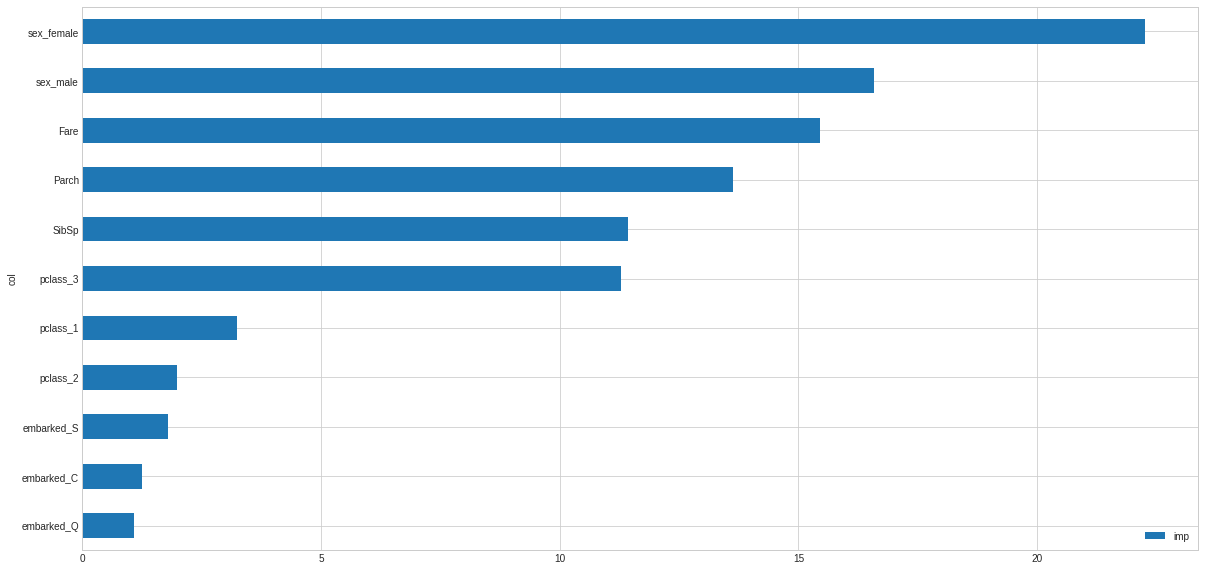

In [110]:
feat_importancia(catboost_model, X_treino)

Esse gráfico mostram a relevância de cada variável. Com isso, pode ser feito uma redução de dimensionalidade, eliminando as variáveis que não contribuem para o modelo.

Além disso, pode ser feito uma melhoria tanto nas variáveis que são muito importantes para o modelo quanto para as variáveis que são pouquíssimas relevantes. 



## Precision e Recall

Vamos plotar algumas métricas que medem a acurácia do modelo.
São elas:

* **Precision (P):** matematicamente é igual a $\frac{VP}{VP + FP}$, onde $VP = $ Verdadeiros Positivos e $FP = $ Falsos positivos. Dentre todas as classificações positivas, quantas estão corretas? É ideal em casos que falsos positivos são mais prejudiciais que falsos negativos. 
* **Recall (R):** matematicamente é igual a $\frac{VP}{VP + FN}$, onde $VP = $ Verdadeiros Positivos e $FP = $ Falsos negativos. Dentre todas os dados que tenham valor esperado positivo, quantas foram classificadas corretamente? É ideal em casos que falsos negativos são mais prejudiciais que falsos positivos. 
* **F1 Score:** matematicamente igual a $\frac{2 * P * R}{P + R} $. Média harmônica de Precision e Recall, portanto, se algum deles for muito baixo, essa métrica também será baixa. 

Todas essas métricas varia de 0 a 1.

In [111]:
metricas = ['Precision', 'Recall', 'F1', 'AUC']

eval_metricas = catboost_model.eval_metrics(treino_pool,
                                            metrics=metricas,
                                            plot=True)

for metrica in metricas:
  print(str(metrica) + ": {}".format(np.mean(eval_metricas[metrica])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precision: 0.835335023344254
Recall: 0.6761117647058825
F1: 0.7472783478969373
AUC: 0.8841195301617916


Recall está baixo, portanto, previu muitos casos que sobreviveram como não sobreviveram. 

Já Precision está relativamente alto, logo, poucos casos em que previu que sobreviveu quando não. 

# Submissão

Vamos avaliar o modelo agora no conjunto de teste.

Para isso, o conjunto de teste deve ter o mesmo formato que o conjunto de treino.

In [112]:
X_treino.head()

,SibSp,Parch,Fare,pclass_1,pclass_2,pclass_3,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
PassengerId,,,,,,,,,,,
1,1,0,7.2500,0,0,1,0,1,0,0,1
2,1,0,71.2833,1,0,0,1,0,1,0,0
3,0,0,7.9250,0,0,1,1,0,0,0,1
4,1,0,53.1000,1,0,0,1,0,0,0,1
5,0,0,8.0500,0,0,1,0,1,0,0,1


In [113]:
teste.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [114]:
# Codificação binária para as variáveis
teste_embarked = pd.get_dummies(teste.Embarked, prefix='embarked')

teste_sex = pd.get_dummies(teste.Sex, prefix='sex')

teste_pclass = pd.get_dummies(teste.Pclass, prefix='pclass')


In [117]:
# Combinar os dataframes

teste = pd.concat([teste,
                   teste_embarked,
                   teste_sex,
                   teste_pclass], axis = 1)

teste.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
PassengerId,,,,,,,,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,1,0,0,1,0,0,1
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0,1,1,0,0,0,1
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,1,0,0,1,0,1,0
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0,1,0,1,0,0,1
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,0,1,1,0,0,0,1


Agora o conjunto de teste possui as colunas que `df_cont_enc` também possui. 

Vamos selecionar apenas as colunas desejadas para a previsão.

In [118]:
s_colunas = X_treino.columns

In [119]:
previsoes = catboost_model.predict(teste[s_colunas])

In [120]:
previsoes[:20]

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1])

In [136]:
modelo_submissao = pd.DataFrame(index = teste.index)
modelo_submissao['Survived'] = previsoes
modelo_submissao.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [137]:
modelo_submissao['Survived'] = modelo_submissao['Survived'].astype(int)

In [139]:
df_acertos = abs(modelo_submissao - submissao)
df_acertos

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,0
...,...
1305,0
1306,0
1307,0


In [146]:
acertos = len(df_acertos) - int(df_acertos.sum())
taxa_acertos = acertos / len(df_acertos)
acertos, taxa_acertos

(388, 0.9282296650717703)

Podemos ver que houve uma taxa de acerto de quase 93%, um valor bem alto. É interessante essa taxa alta para o  CatBoost, um modelo pouco conhecido, portanto, é um algoritmo interessante de se estudar mais a fundo. 

Algumas sugestões para melhorar a análise e o modelo, além das já citadas até aqui:

* Aplicar um redução de dimensionalidade (PCA, por exemplo) para eliminar os atributos com menos impacto, o que pode até gerar uma eficiência maior do modelo.
* Há diversos hiperparâmetros nos modelos utilizados que foram utilizados os valores padrões. Como seria uma boa forma de escolher esses hiperparâmetros ótimos ou subótimos? 

Com isso, termino essa análise.